## Motivation {.unnumbered}

Before futher analysis, identifying and removing poor quality cells is a critical step to ensure quality of the data and prevent misinformative results. Crucial parameters indicative of poor quality cells include the fraction of mitochondrial, ribosomal, haemoglobin, T/B-cell recepter (TCR/BCR) reads. High mitochondrial fractions is a typical characteristic of apoptotic cells in scRNAseq data. High ribosomal & haemoglobin fractions indicates poor sample quality and RBC contamination. Cells with high TCR & BCR fractions are indicative of T/B-cell doublets.  

In [ ]:
## set up environment
suppressMessages({
library(scUnify)
library(clustree)
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE247917")})

## import seurat objects
obj.list <- qread("seurat/1_processing/1.3_GSE247917_demux.qs")

## Merge Seurat Objects

In [5]:
obj <- merge(obj.list[[1]], obj.list[2:length(obj.list)])
obj <- join_layers(obj)

## Remove VDJ Genes {#sec-remove_vdj_genes}
In the case of T/B-cells, removing VDJ genes could be critical prior to subsequence steps to avoid cell clustering by VDJ genes, especially by isotype such as IgG and IgM for B-cells. Below is a wrapper function to remove VDJ genes from the Seurat object.

:::{.callout-warning}
Before removing VDJ genes, please run Seurat::NormalizeData() to ensure library size is normalized with VDJ genes included.
:::

In [6]:
# normalize counts and remove vdj genes
obj <- NormalizeData(obj)
obj <- remove_vdj_genes(obj, bcr = T, tcr = T)

Normalizing layer: counts

Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“Different cells and/or features from existing assay RNA”


## Calculate Gene Fractions {#sec-calculate_gene_fractions}
  
The function below will perform the calculations of key quality control parameters for every cell but will not filter any cells yet. This is done by calculating the no. of selected reads over the no. of total reads for every cell.

In [7]:
# run calculate gene fractions if haven't done so already
obj <- calculate_fractions(obj)

## Filter By Gene Fractions {#sec-filter_by_gene_fractions}

Following @sec-calculate_gene_fractions, we will now set thresholds to remove poor quality cells mentioned above. There are generally 2 approaches - either hard and soft threshold could be set to remove cells. The difference between the methods is that using a soft threshold means that you are defining poor quality cells based on the distribution of the population, which ensures a good proportion of cells will remain and hopefully are the cells of interest. Generally we recommend using a <u>soft</u> threshold for quality control, especially in the case where users have multiple sequencing runs, as these threshold may subject to change depending on cell populations, batch effects etc.

For both approaches, a threshold is set for the following essential quality control parameters, including nFeatures_RNA, nCount_RNA, mitochondrial, haemoglobin fraction. Typically mitochondrial fraction threshold is set at 10% for human and 5% for mouse.

:::{.callout-warning}
If VDJ genes were removed earlier, recalculating nFeature and nCount is critical to remove cells that only contain VDJ genes which are likely empty droplets contaminated with RNA. This was done automatically in the Seurat object when VDJ were first removed.
:::

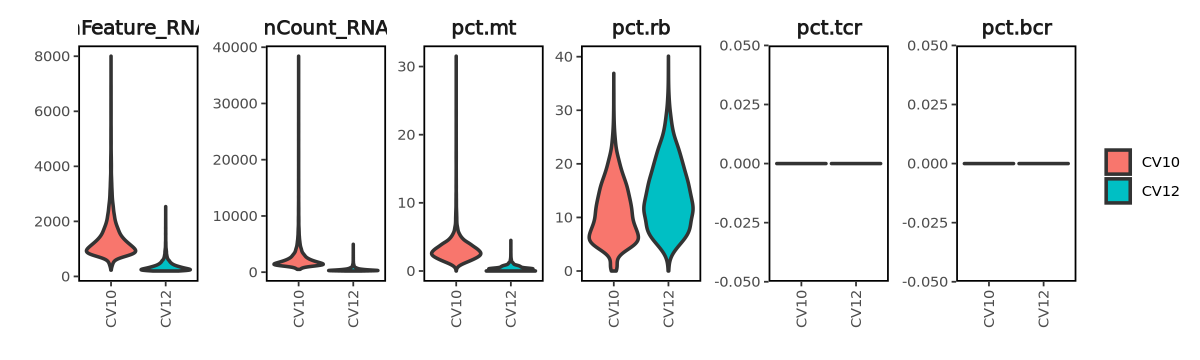

In [10]:
## Visualize each quality control parameter for each sequencing run
options(repr.plot.width=10, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = samples, y = values, fill = samples)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~ measures, scales = "free", ncol = 6) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()
    

### Hard Threshold
> Given both our sequencing runs contain the similar composition of cells and distributions of the quality control parameters, we can apply the same hard thresholds to both runs. 

Warning message:
“Removed 110550 rows containing missing values or values outside the scale range
(`geom_hline()`).”


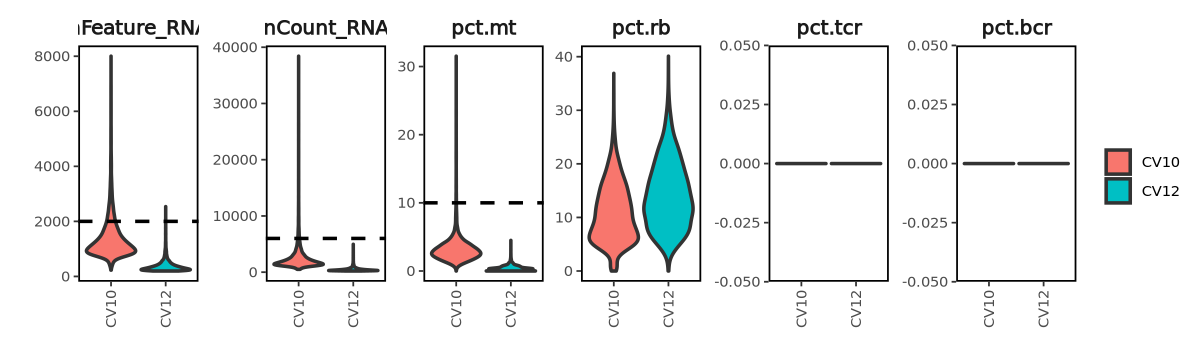

In [11]:
## Visualize each quality control parameter for each sequencing run
options(repr.plot.width=10, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ## define hard threshold
    mutate(
        yintercept = case_when(
            measures == "nCount_RNA" ~ 6000,
            measures == "nFeature_RNA" ~ 2000,
            measures == "pct.mt" ~ 10,
            .default = NULL)) %>%
            
    ggplot(aes(x = samples, y = values, fill = samples)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~ measures, scales = "free", ncol = 6) +
    geom_hline(aes(yintercept = yintercept), color = "black", linetype = "dashed", size = 1) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = ""), color = guide_none()) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

> After visualization we removed cells based on the following criteria : 
> 
> * nCount_RNA > 8000
> * nFeature_RNA < 200 or > 2000
> * pct.mt > 10%
> * pct.hb > 0%
> 
> \> 90% cells remains from each sequencing run after quality control filter by hard threshold.

In [12]:
## set hard threshold
obj@meta.data <- obj@meta.data %>%
    mutate(hardqc = case_when(
        .$nCount_RNA > 6000 ~ "Fail",
        .$nFeature_RNA > 2000 ~ "Fail",
        .$nFeature_RNA < 200 ~ "Fail",
        .$pct.mt > 10 ~ "Fail",
        .$pct.hb > 0 ~ "Fail",
        .default = "Pass"))
qc_report(obj, column = "hardqc", sample = "samples")

84.9% (16551) of cells remains - CV10

99.7% (17319) of cells remains - CV12



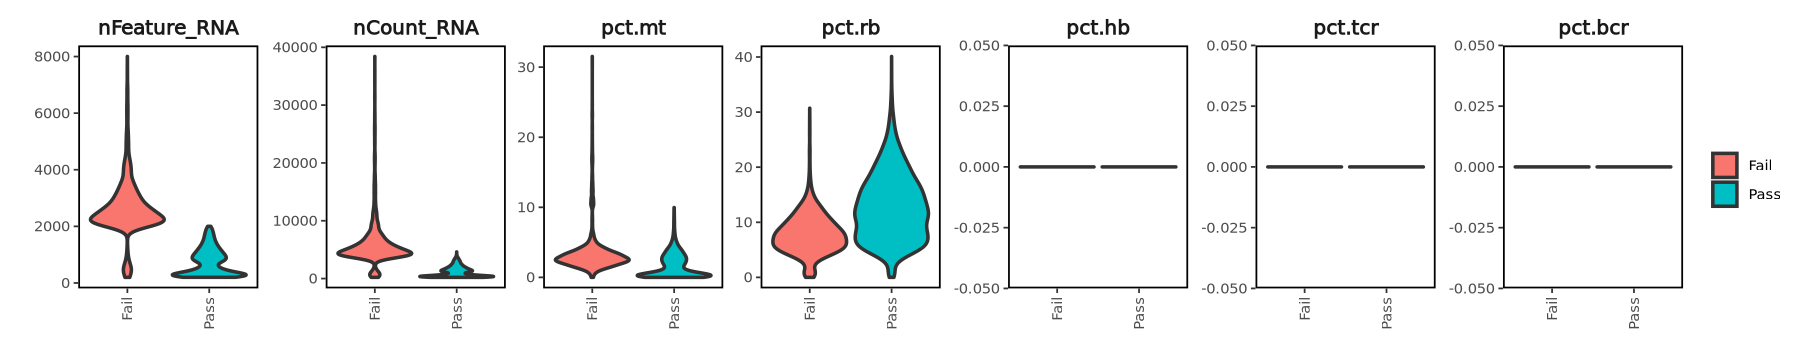

In [13]:
## Visualize the quality control parameters for good/poor quality cells
options(repr.plot.width=15, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = hardqc, y = values, fill = hardqc)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~measures, scales = "free", ncol = 7) +
    guides(fill = guide_legend(title = "")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("") +
    theme_border() + 
    facet_aes()
    

### Soft Threshold

As a comparison, we will perform soft threshold cutoff to remove outlier (poor quality) cells based on population distribution. To do so, we have adapted the median absolute deviation (MAD) method [[see details]](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html) to determine outlier cells from each sample based on the quality control filter mentioned above. Below is a wrapper function to calculate thresholds for the specified quality control parameters within 5 MAD deviations and determine outlier cells. Note the function does not perform the filtering yet.

> \> 85% cells remains from each sample after quality control filter by soft threshold.

In [14]:
## calculate mad and determine outlier cells
obj <- calculate_mad(obj, columns = c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.hb"), stdev = 5, samples = "samples")

88.9% (17321) of cells remains - CV10

91.8% (15950) of cells remains - CV12



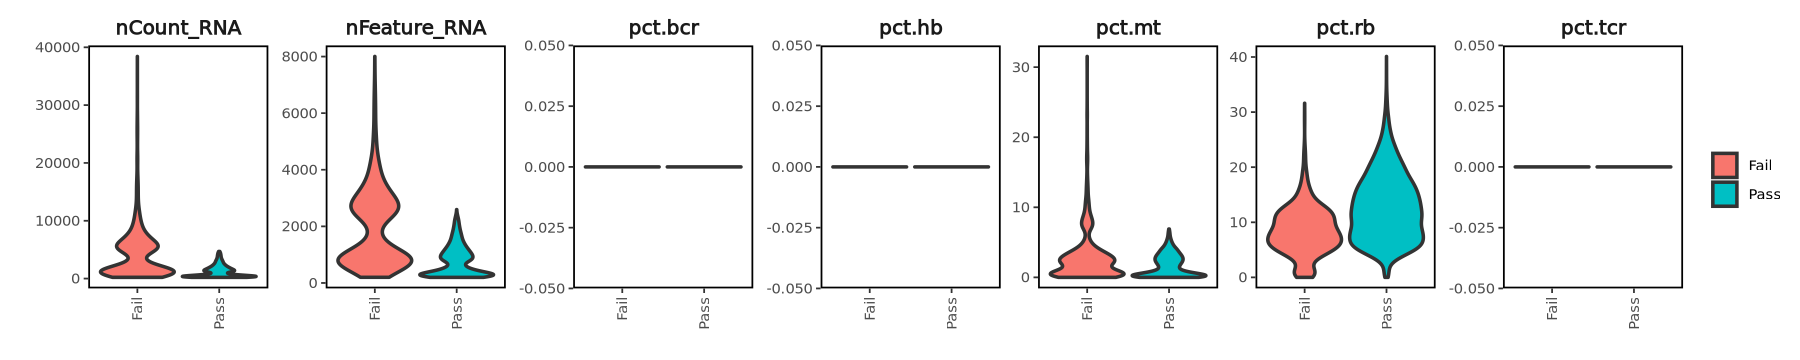

In [15]:
## Visualize the quality control parameters for good/poor quality cells
options(repr.plot.width=15, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    ggplot(aes(x = softqc, y = values, fill = softqc)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~measures, scales = "free", ncol = 7) +
    guides(fill = guide_legend(title = "")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("") +
    theme_border() + 
    facet_aes()
    

### Inspecting QC
Finally we will move forward with the soft threshold, Here we will do a final inspection to ensure we are keeping the high quality cells.

In [16]:
# make scatter plots
fs1.plot <- list()
fs2.plot <- list()
fs3.plot <- list()
fs4.plot <- list()

obj_list <- SplitObject(obj, split.by = "samples")
for(x in 1:length(obj_list)){
    Idents(obj_list[[x]]) <- "samples"
    fs1.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "nCount_RNA", "nFeature_RNA", pt.size = 0.5, plot.cor = T) + NoLegend()
    fs2.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "nCount_RNA", "pct.mt", pt.size = 0.5, plot.cor = T) + NoLegend()
    fs3.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "pct.rb", "pct.mt", pt.size = 0.5, plot.cor = T) + NoLegend()}

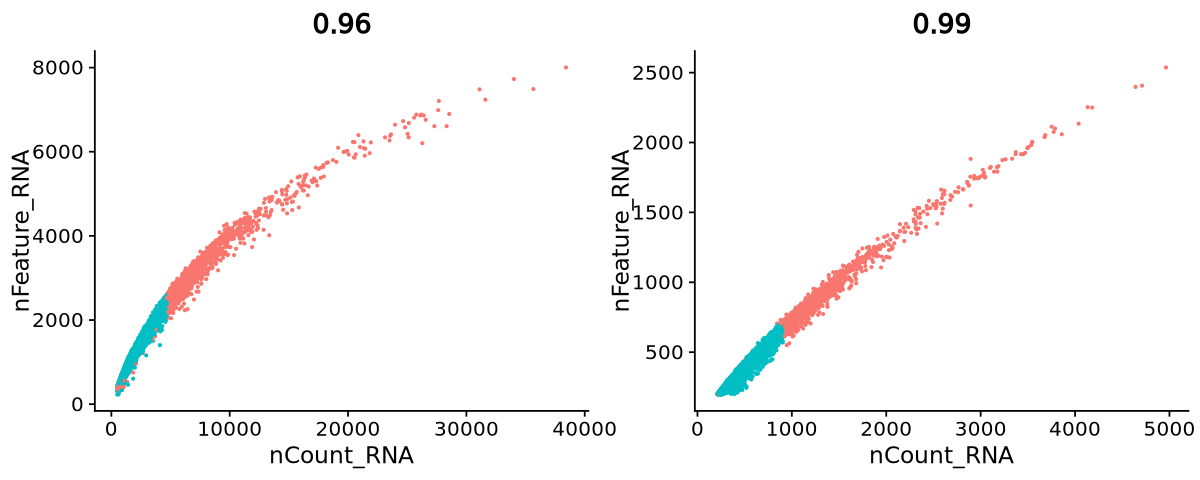

In [17]:
# nCount_RNA vs nFeature_RNA
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs1.plot, ncol = 2)

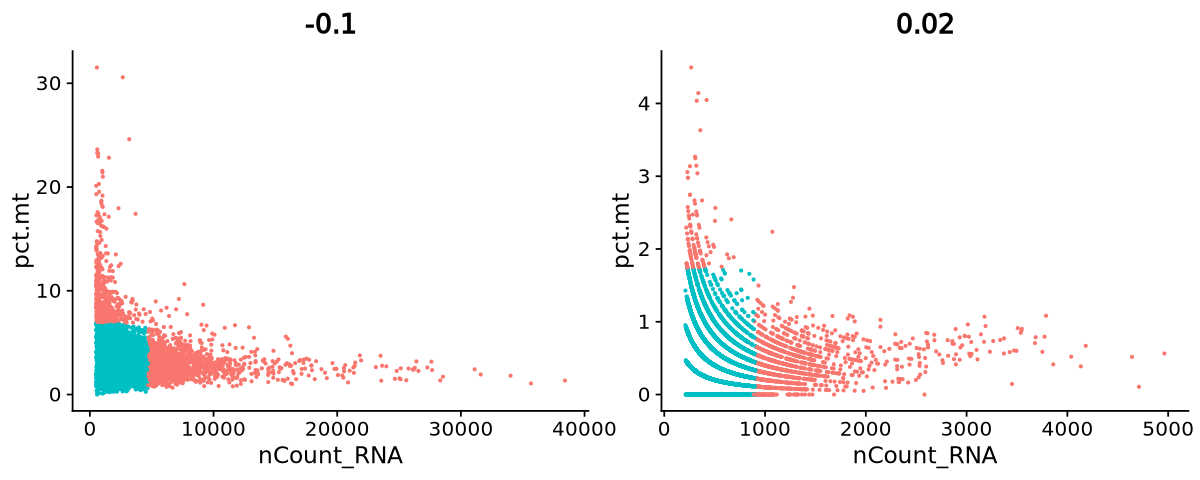

In [18]:
# nCount_RNA vs mitochondrial fraction
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs2.plot, ncol = 2)

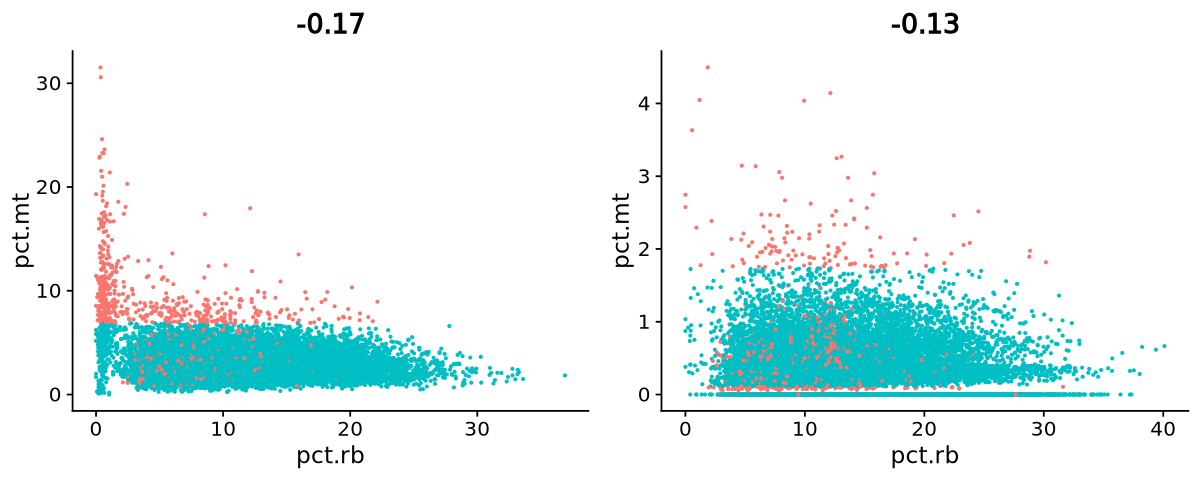

In [19]:
# ribosomal fraction vs mitochondrial fraction
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs3.plot, ncol = 2)

## T/B-cell Doublets
T/B-cells represent the most abundant of immune cell populations and have a high chance to be sequenced together as doublets. T and B-cells can be characterized by TCR-VDJ and BCR-VDJ gene expression respectively, the TCR/BCR expressions are mutually exclusive. Therefore T/B-cell doublets can be manually identified and removed if the TCR/BCR fraction is high.

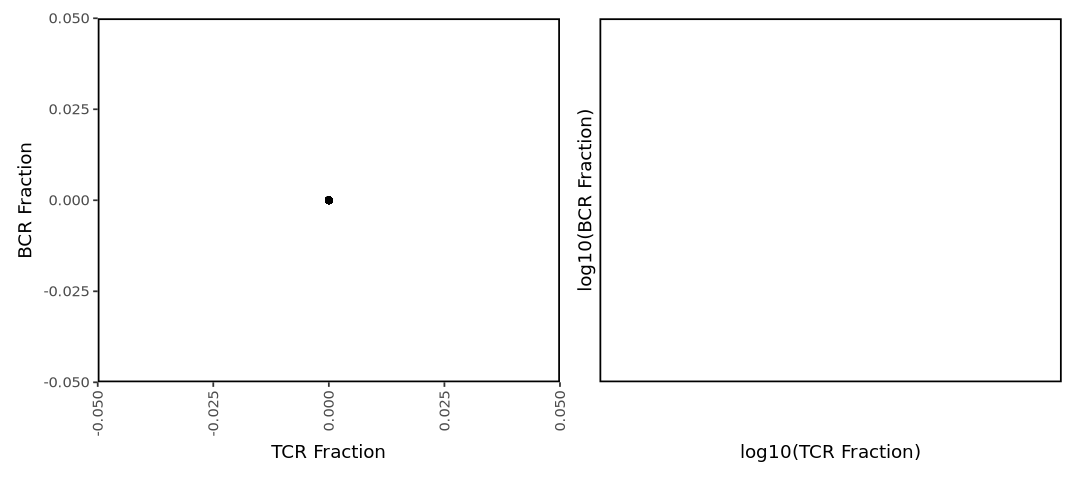

In [ ]:
## visualize BCR/TCR read fractions
options(repr.plot.width=9, repr.plot.height= 4)
p1 <- obj@meta.data %>%
    ggplot(aes(x = pct.tcr, y = pct.bcr)) +
    geom_point() +
    theme_border() +
    geom_hline(yintercept = 5) +
    geom_vline(xintercept = 0.05) +
    xlab("TCR Fraction") +
    ylab("BCR Fraction")
p2 <- obj@meta.data %>%
    ggplot(aes(x = log10(pct.tcr), y = log10(pct.bcr))) +
    geom_point() +
    theme_border() +
    geom_hline(yintercept = log10(5)) +
    geom_vline(xintercept = log10(0.05)) +
    xlab("log10(TCR Fraction)") +
    ylab("log10(BCR Fraction)")
p1 + p2

## Remove Poor Quality Cells {#sec-filtercells}
Combining the soft threshold filters together with outputs from MULTIseqDemux, DoubletFinder, T/B Doublet (see previous chapters), we will remove the poor quality cells altogether.

> \> 60% of cells remain from each sample after all quality control filters.

In [23]:
## make a column of cells to keep, putting together outputs from multiseqdemux, doubletfinder, t/b doublets and quality control
obj@meta.data <- obj@meta.data %>%
    mutate(finalqc = ifelse(
        MULTI.global == "Singlet" & softqc == "Pass", "Pass", "Fail"))
qc_report(obj, column = "finalqc", sample = "samples")

75.6% (14739) of cells remains - CV10

39.3% (6826) of cells remains - CV12



## Quick Processing

The wrapper function below will perform library normalization (log1p), feature selection, scaling, principal component analysis (PCA), batch-correction with Harmony (optional), Louvain clustering (res = 0.4) and UMAP projection.

Finding variable features for layer counts



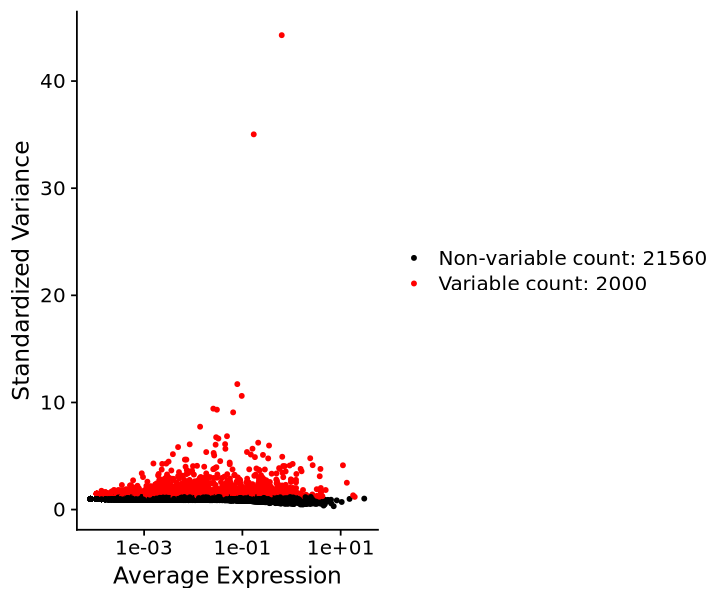

In [29]:
options(repr.plot.width=6, repr.plot.height=5)
DefaultAssay(obj) <- "RNA"
obj <- FindVariableFeatures(obj, nfeatures = 2000)
VariableFeaturePlot(obj, assay = "RNA")

In [30]:
obj <- integrate_v4(obj, split.by = "samples", assay = "RNA", nfeatures = 2000, method = "rpca", k.weight = 100)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 21883 by 19484

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 383 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21883 genes

Computing corrected count matrix for 21883 genes

Calculating gene attributes

Wall clock passed: Time difference of 1.273676 mins

Determine variable features

Centering data matrix

Getting residuals for block 1(of 4) for counts dataset

Getting residuals for block 2(of 4) for counts dataset

Getting residuals for block 3(of 4) for counts dataset

Getting residuals for block 4(of 4) for counts dataset

Centering data matrix

Finished calculating residuals for counts

Set default assay to SCT

Running SCTra

  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_ACTATCTGTATATGAG-1 .. CV10_ATGTGTGGTATTCTCT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_ATGTGTGGTCGACTAT-1 .. CV10_CATTATCAGGTCATCT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_CATTATCAGTACGATA-1 .. CV10_CGGAGTCTCTCTTGAT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_CGGAGTCTCTTAGCCC-1 .. CV10_CTTAACTTCGAATGGG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_CTTAACTTCGCCATAA-1 .. CV10_GCCTCTACAATCAGAA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_GCCTCTACACAGCCCA-1 .. CV10_GTACGTATCTGGTATG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_GTACTCCAGACTCGGA-1 .. CV10_TATCAGGTCTTGCATT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_TATCAGGTCTTGGGTA-1 .. CV10_TGGACGCAGCCCAATT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 1484 cells: CV10_TGGACGCAGCGACGTA-1 .. CV10_TTTGTCATCTTTAGGG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%
[1] 1


Warning message:
“Different cells and/or features from existing assay SCT”
sct.model: counts on 2000 cells: CV12_AAACCTGAGAGCCTAG-1 .. CV12_ACTTACTGTTTACTCT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_ACTTACTTCAATCACG-1 .. CV12_CAAGATCCAAGCTGTT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_CAAGATCCAATGAAAC-1 .. CV12_CCTAAAGGTGGAAAGA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_CCTAAAGGTGTCAATC-1 .. CV12_CTCACACAGGTACTCT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_CTCACACAGTGGGCTA-1 .. CV12_GATCGTATCACGGTTA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_GATCGTATCATACGGT-1 .. CV12_GGGATGACAGCTATTG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_GGGATGACAGCTCGCA-1 .. CV12_TACTTGTGTCGGCTCA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_TACTTGTGTCTCTTAT-1 .. CV12_TGCTGCTTCGCCCTTA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%


sct.model: counts on 1366 cells: CV12_TGCTGCTTCGGCGCTA-1 .. CV12_TTTGTCATCTGCCCTA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 12868 genes



  |======================================================================| 100%
[1] 2


Warning message:
“Different cells and/or features from existing assay SCT”
Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.1 GiB”
Warning message:
“Assay integrated changing from Assay to SCTAssay”
Warning message:
“Different cells and/or features from existing assay SCT”


PC_ 1 
Positive:  IL7R, MALAT1, RPS12, CD3E, LTB, RPS3, IL32, LEF1, TCF7, INPP4B 
	   ETS1, RPL5, EEF1A1, NKG7, CAMK4, RPL10, RPL13, NELL2, RPS27A, CCL5 
	   RPL3, IL2RG, RPL4, IFITM1, ITK, GNLY, CD69, PDE3B, DDX5, CD247 
Negative:  LYZ, S100A9, FTL, IFI30, CD74, PSAP, FOS, S100A8, VCAN, FTH1 
	   CST3, FCN1, CTSS, SAT1, NAMPT, TYROBP, CYBB, AIF1, SERPINA1, HLA-DRA 
	   NEAT1, S100A6, TNFAIP2, VIM, MNDA, S100A11, PLXDC2, SPI1, CD36, S100A4 
PC_ 2 
Positive:  GNLY, NKG7, PRF1, CCL5, CTSW, CX3CR1, GZMB, FCGR3A, FGFBP2, CST7 
	   MYOM2, CD247, SPON2, KLRD1, IL2RB, SYNE1, GZMA, TGFBR3, FLNA, KLRF1 
	   ADGRG1, PRSS23, ITGB2, AOAH, GZMH, PTGDS, S1PR5, PFN1, SH2D1B, PYHIN1 
Negative:  RPS12, RPLP1, RPL13, RPL10, RPS8, TPT1, IL7R, RPL32, AL138963.4, EEF2 
	   EEF1A1, RPL4, LTB, RPL11, RPS14, RPS18, RPL18A, RPL30, LEF1, RPS23 
	   RPS3A, RPS3, RPL28, RPLP0, RPS27A, RPS13, RPL19, RPL34, RPS15A, RPL29 
PC_ 3 
Positive:  CD74, BANK1, MS4A1, FCRL1, HLA-DRA, AFF3, RALGPS2, CD79A, HLA-DPB1, HLA-DQA1

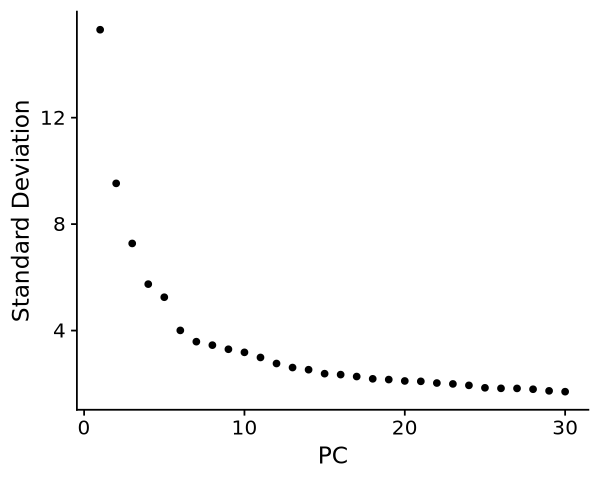

In [31]:
options(repr.plot.width=5, repr.plot.height=4)
obj <- RunPCA(obj)
ElbowPlot(obj, ndims = 30, reduction = "pca")

In [32]:
obj <- RunUMAP(obj, dims = 1:7, reduction = "pca", reduction.name = "umap", assay = "RNA", verbose = FALSE)

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



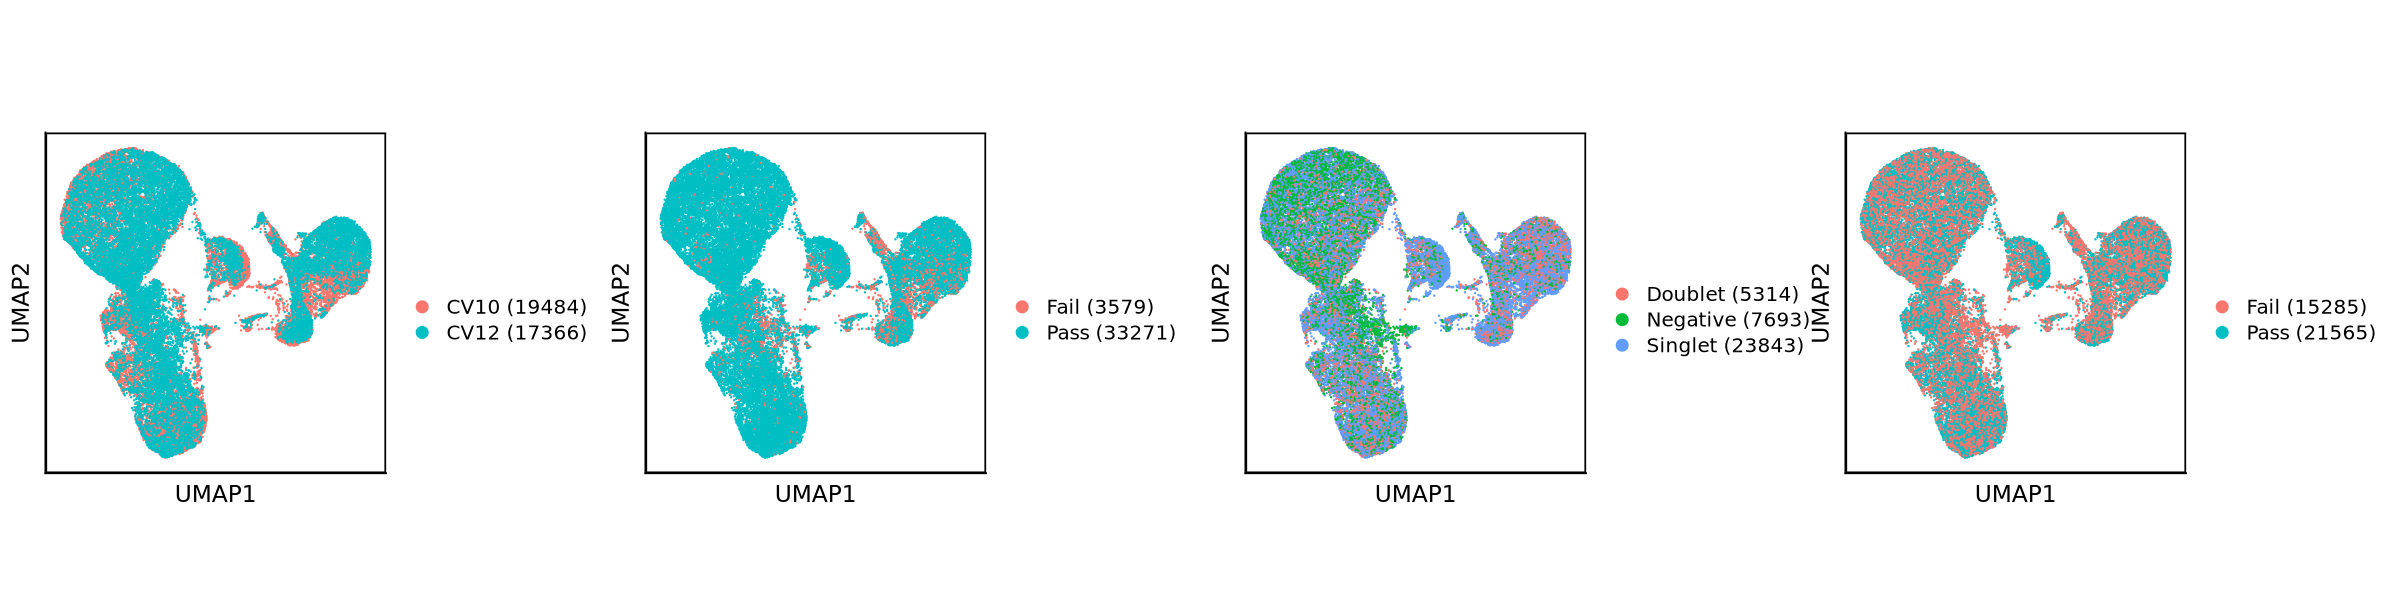

In [44]:
options(repr.plot.width=20, repr.plot.height=5)
p1 <- scUMAP(obj, reduction = "umap", group.by = "samples", count = T)
p2 <- scUMAP(obj, reduction = "umap", group.by = "softqc", count = T)
p3 <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global", count = T)
p4 <- scUMAP(obj, reduction = "umap", group.by = "finalqc", count = T)
plot_grid(p1, p2, p3, p4, ncol = 4, align = "hv")

In [ ]:
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:7, verbose = F)
obj <- FindClusters(obj, resolution = seq(0.1, 1, 0.1), algorithm = 1, verbose = F)
clustree <- clustree(obj@meta.data, prefix = paste0("integrated_snn_res."))

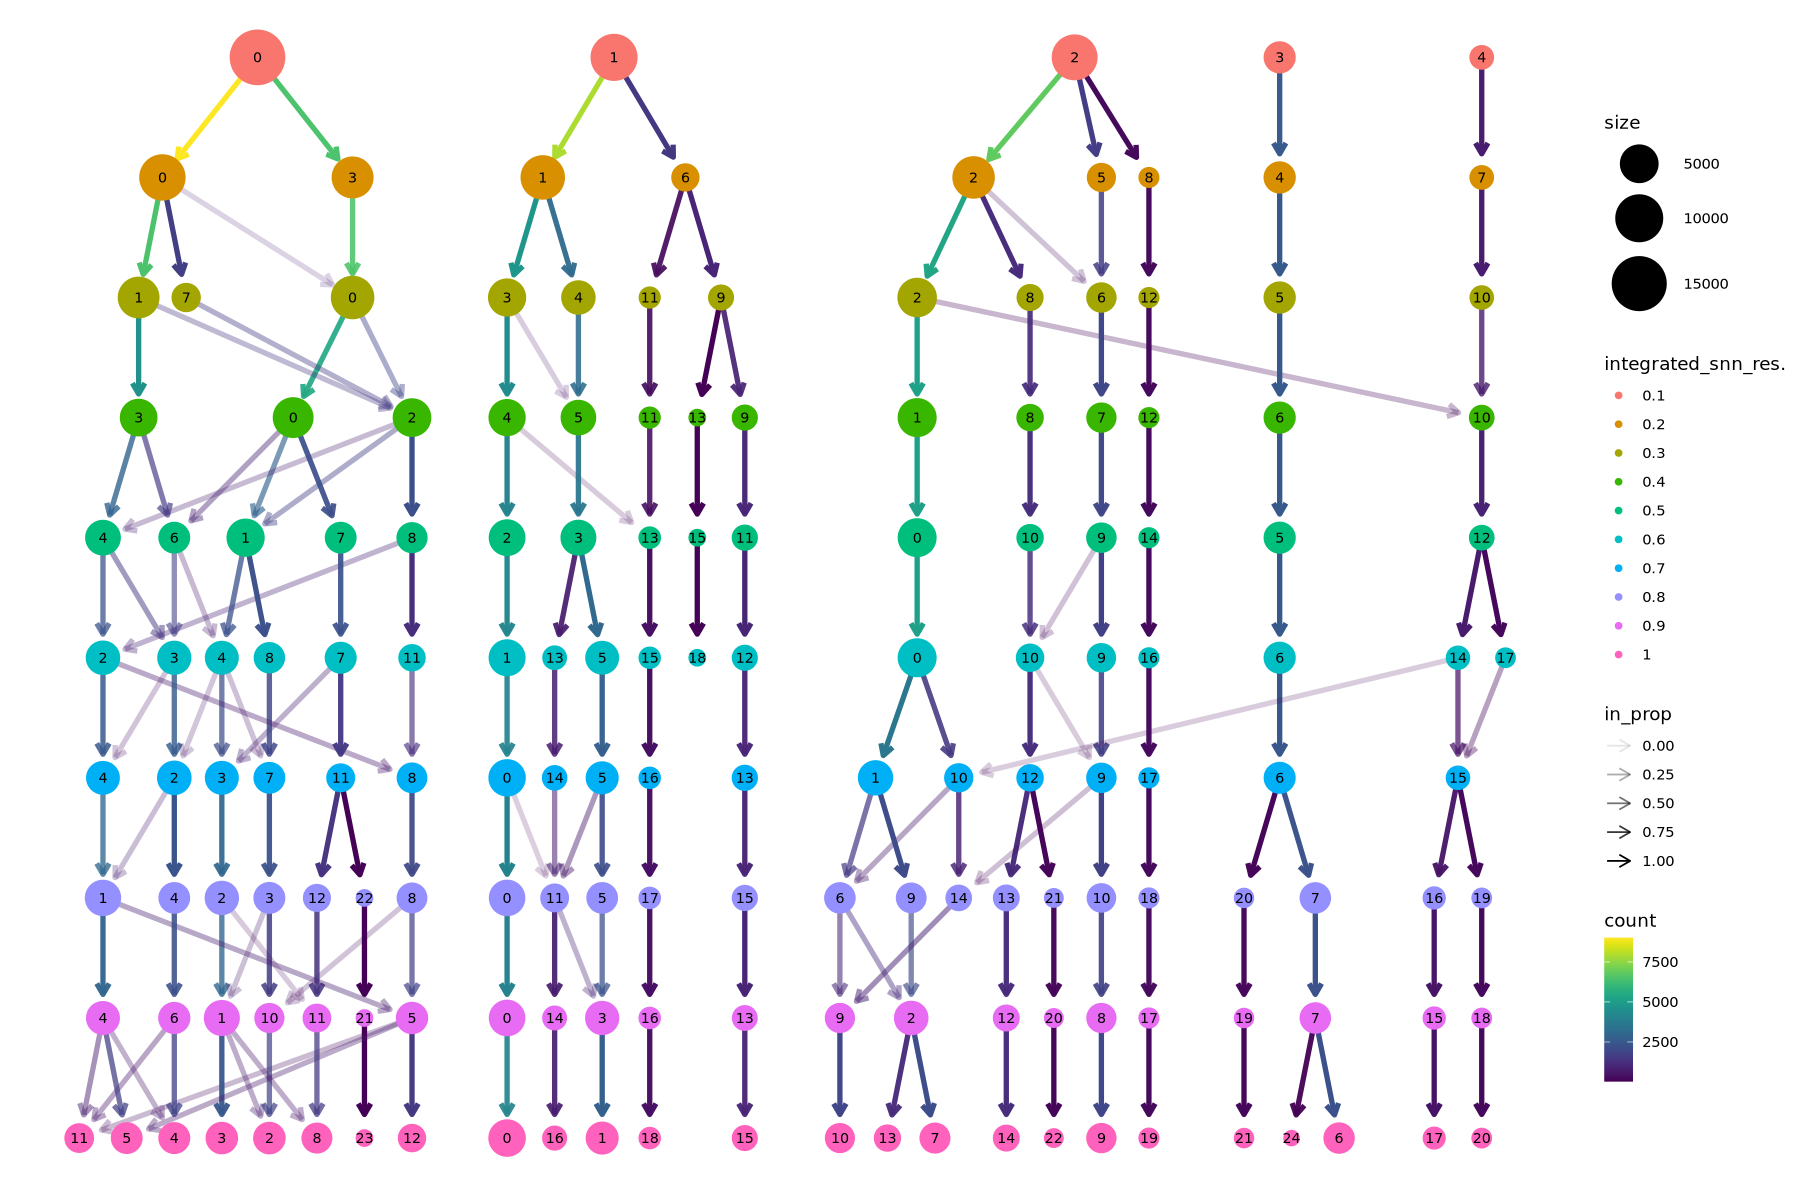

In [38]:
options(repr.plot.width=15, repr.plot.height=10)
print(clustree)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


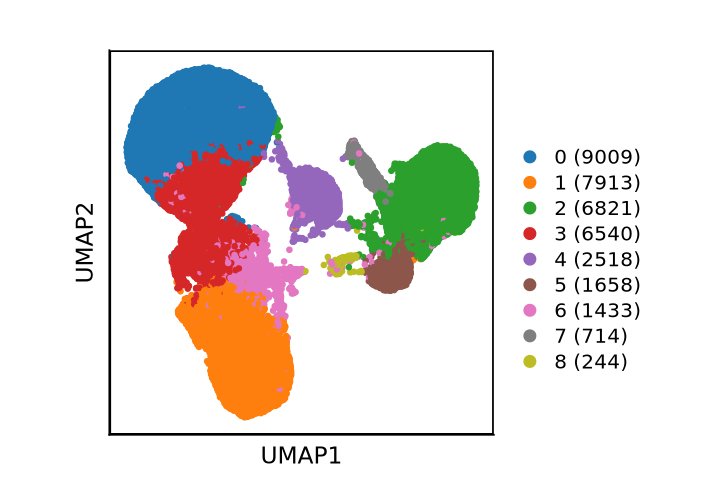

In [43]:
options(repr.plot.width=6, repr.plot.height=4)
scUMAP(obj, reduction = "umap", group.by = "integrated_snn_res.0.2", count = T, pt.size = 1.2, cols = palette_list[["vega_10"]])

## Session Info {.unnumbered}

In [45]:
qsave(obj, file = "seurat/1_processing/1.4_GSE247917_qc.qs")

In [46]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] clustree_0.5.0              ggraph_2.1.0               
 [3] scUnify_0.0.0.9000          ComplexHeatmap_2.16.0      
 [5] DoubletFinder_2.0.4         scDblFinder_1